In [1]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn import metrics
from sklearn.random_projection import GaussianRandomProjection,SparseRandomProjection
from sklearn.decomposition import PCA, FastICA,TruncatedSVD
%pylab inline 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:90% !important;}</style>"))

conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%time
sql_query ="SELECT a.[PurchaseDate] \
      ,MONTH(a.[PurchaseDate]) Month \
      ,a.[PartnerID] \
      ,IIF(SEX='M',1,0) SEX \
      ,IIF(DATEDIFF(YEAR,[BirthDate],a.[PurchaseDate])> 100 , 0 , DATEDIFF(YEAR,[BirthDate],a.[PurchaseDate])) Age \
      ,[CityID] \
      ,DATEDIFF(DAY, [FirstVisit],a.[PurchaseDate])/30.0 LT  \
      ,DATEDIFF(DAY, t.LastDate,a.[PurchaseDate])/30.0 LastVisit_M  \
      ,[FirstVisit] \
      ,[QNTVisits] \
      ,[SumSMS] \
      ,[SumQuantity] \
      ,[SumSumma] \
      ,[AVGSumma] \
      ,[SUMM1] \
      ,[SUMM2] \
      ,[SUMM3] \
      ,[SUMM4] \
      ,[SUMM5] \
      ,[SUMM6] \
      ,[SUMM7] \
      ,[SUMM8] \
      ,[SUMM9] \
      ,[SUMM10] \
      ,[SUMM11] \
      ,[SUMM12] \
      ,[SUMP1k] \
      ,[SUMP3k] \
      ,[SUMP6k] \
      ,[SUMP12k] \
      ,[SUMP50k] \
      ,[SUMKolco] \
      ,[SUMSERGI] \
      ,[SUMPODVES] \
      ,[SUMCEP] \
      ,[SUMBRASLET] \
      ,[SUMKOLE] \
      ,[SUMCheap] \
      ,[SUMExpensive] \
      ,[SUMPremium] \
      ,[SUMMiddle] \
      ,[SUMZoloto] \
      ,[SUMSerebro] \
      ,[SUMColorBlack] \
      ,[SUMColorRed] \
      ,[SUMColorYellow] \
      ,[SUMColorWhite] \
      ,[SUMColor3] \
      ,[SUMColor2] \
      ,[SUMGroupBaza] \
      ,[SUMGroupClassic] \
      ,[SUMGroupModa] \
      ,[SUMGroupModul] \
      ,[SUMGroupSouvenir] \
      ,[SUMGroupTrend] \
      ,IIF(LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID,0,1) LastPurchase \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMZoloto],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMZoloto] IS NULL,0,1)), \
      1,0) NextGold \
  FROM [Gold585].[dbo].[TempPurch3] a left join [Gold585].[dbo].TempDate2 t on a.PartnerID = t.PartnerID and a.PurchaseDate = t.PurchaseDate \
  order by PartnerID, PurchaseDate"

df = pd.read_sql(sql_query,conn)
df.head()

Wall time: 13min 7s


необходимые таблицы для прогноза - TempPurch3 и ##TempDate или (TempDate)

In [152]:
%%time
sql_query ="SELECT a.[PurchaseDate] \
      ,MONTH(a.[PurchaseDate]) Month \
      ,a.[PartnerID] \
      ,IIF(SEX='M',1,0) SEX \
      ,IIF(DATEDIFF(YEAR,[BirthDate],a.[PurchaseDate])> 100 , 0 , DATEDIFF(YEAR,[BirthDate],a.[PurchaseDate])) Age \
      ,[CityID] \
      ,DATEDIFF(DAY, [FirstVisit],a.[PurchaseDate])/30.0 LT  \
      ,DATEDIFF(DAY, t.LastDate,a.[PurchaseDate])/30.0 LastVisit_M  \
      ,[FirstVisit] \
      ,[QNTVisits] \
      ,[SumSMS] \
      ,[SumQuantity] \
      ,[SumSumma] \
      ,[AVGSumma] \
      ,[SUMM1] \
      ,[SUMM2] \
      ,[SUMM3] \
      ,[SUMM4] \
      ,[SUMM5] \
      ,[SUMM6] \
      ,[SUMM7] \
      ,[SUMM8] \
      ,[SUMM9] \
      ,[SUMM10] \
      ,[SUMM11] \
      ,[SUMM12] \
      ,[SUMP1k] \
      ,[SUMP3k] \
      ,[SUMP6k] \
      ,[SUMP12k] \
      ,[SUMP50k] \
      ,[SUMKolco] \
      ,[SUMSERGI] \
      ,[SUMPODVES] \
      ,[SUMCEP] \
      ,[SUMBRASLET] \
      ,[SUMKOLE] \
      ,[SUMCheap] \
      ,[SUMExpensive] \
      ,[SUMPremium] \
      ,[SUMMiddle] \
      ,[SUMZoloto] \
      ,[SUMSerebro] \
      ,[SUMColorBlack] \
      ,[SUMColorRed] \
      ,[SUMColorYellow] \
      ,[SUMColorWhite] \
      ,[SUMColor3] \
      ,[SUMColor2] \
      ,[SUMGroupBaza] \
      ,[SUMGroupClassic] \
      ,[SUMGroupModa] \
      ,[SUMGroupModul] \
      ,[SUMGroupSouvenir] \
      ,[SUMGroupTrend] \
      ,IIF(LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID,0,1) LastPurchase \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMZoloto],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMZoloto] IS NULL,0,1)), \
      1,0) NextGold \
  FROM [Gold585].[dbo].[TempPurch3] a left join [Gold585].[dbo].TempDate2 t on a.PartnerID = t.PartnerID and a.PurchaseDate = t.PurchaseDate \
  order by PartnerID, PurchaseDate"

df = pd.read_sql(sql_query,conn)
df.head()

Wall time: 6min 37s


In [3]:
pred = df[df['LastPurchase']==1].fillna(0).reset_index(drop=True)
predId = pd.DataFrame(df['PartnerID'][df['LastPurchase']==1],columns=['PartnerID']).reset_index(drop=True)
data = df[df['LastPurchase']!=1].fillna(0).reset_index(drop=True)
pred.head()

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,SUMColor3,SUMColor2,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend,LastPurchase,NextGold
0,2016-01-24,1,2,0,46,35,0.000000,0.000000,2016-01-24,1,...,0,1,0,2,0,0,0,0,1,0
1,2016-01-24,1,3,1,49,72,0.000000,0.000000,2016-01-24,1,...,0,0,0,1,0,0,0,0,1,0
2,2018-08-25,8,4,0,0,92,20.733333,0.100000,2016-12-11,8,...,0,1,2,4,0,6,0,0,1,0
3,2017-01-14,1,6,0,31,32,11.866666,11.866666,2016-01-24,2,...,0,0,0,2,0,0,0,0,1,0
4,2016-01-24,1,9,0,0,122,0.000000,0.000000,2016-01-24,1,...,0,0,0,1,0,0,0,0,1,0


In [4]:
data.head(10)

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,SUMColor3,SUMColor2,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend,LastPurchase,NextGold
0,2016-12-11,12,4,0,0,92,0.000000,0.000000,2016-12-11,1,...,0,0,0,1,0,0,0,0,0,0
1,2016-12-18,12,4,0,0,92,0.233333,0.233333,2016-12-11,2,...,0,0,0,2,0,0,0,0,0,0
2,2018-02-14,2,4,0,0,92,14.333333,14.100000,2016-12-11,3,...,0,0,0,3,0,0,0,0,0,0
3,2018-06-07,6,4,0,0,92,18.100000,3.766666,2016-12-11,4,...,0,0,2,3,0,0,0,0,0,0
4,2018-07-17,7,4,0,0,92,19.433333,1.333333,2016-12-11,5,...,0,0,2,3,0,1,0,0,0,0
5,2018-08-17,8,4,0,0,92,20.466666,1.033333,2016-12-11,6,...,0,1,2,3,0,3,0,0,0,0
6,2018-08-22,8,4,0,0,92,20.633333,0.166666,2016-12-11,7,...,0,1,2,3,0,5,0,0,0,0
7,2016-01-24,1,6,0,30,32,0.000000,0.000000,2016-01-24,1,...,0,0,0,2,0,0,0,0,0,1
8,2014-08-07,8,12,0,40,29,0.000000,0.000000,2014-08-07,1,...,0,0,0,1,0,0,0,0,0,1
9,2015-03-28,3,12,0,41,29,7.766666,7.766666,2014-08-07,2,...,0,1,1,1,0,0,0,0,0,1


In [5]:
data.shape

(5697650, 57)

In [6]:
print(data['NextGold'].value_counts())
#print(data['NextSerebro'].value_counts())

1    3356368
0    2341282
Name: NextGold, dtype: int64


In [7]:
data['NextGold'].value_counts()

1    3356368
0    2341282
Name: NextGold, dtype: int64

In [8]:
data.columns

Index(['PurchaseDate', 'Month', 'PartnerID', 'SEX', 'Age', 'CityID', 'LT',
       'LastVisit_M', 'FirstVisit', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4', 'SUMM5',
       'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11', 'SUMM12',
       'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k', 'SUMKolco',
       'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET', 'SUMKOLE', 'SUMCheap',
       'SUMExpensive', 'SUMPremium', 'SUMMiddle', 'SUMZoloto', 'SUMSerebro',
       'SUMColorBlack', 'SUMColorRed', 'SUMColorYellow', 'SUMColorWhite',
       'SUMColor3', 'SUMColor2', 'SUMGroupBaza', 'SUMGroupClassic',
       'SUMGroupModa', 'SUMGroupModul', 'SUMGroupSouvenir', 'SUMGroupTrend',
       'LastPurchase', 'NextGold'],
      dtype='object')

In [10]:
data1 = data[data['NextGold']==1] #.sample(700000)
data0 = data[data['NextGold']!=1]

all_data = data
X = pd.concat([data1,data0],axis=0,ignore_index=True)
X.head()

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,SUMColor3,SUMColor2,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend,LastPurchase,NextGold
0,2016-01-24,1,6,0,30,32,0.000000,0.000000,2016-01-24,1,...,0,0,0,2,0,0,0,0,0,1
1,2014-08-07,8,12,0,40,29,0.000000,0.000000,2014-08-07,1,...,0,0,0,1,0,0,0,0,0,1
2,2015-03-28,3,12,0,41,29,7.766666,7.766666,2014-08-07,2,...,0,1,1,1,0,0,0,0,0,1
3,2016-01-24,1,12,0,42,29,17.833333,10.066666,2014-08-07,3,...,0,1,1,2,0,0,0,0,0,1
4,2016-01-24,1,14,1,23,101,0.000000,0.000000,2016-01-24,3,...,0,0,3,6,0,0,0,0,0,1


In [11]:
X.tail()

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,SUMColor3,SUMColor2,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend,LastPurchase,NextGold
5697645,2018-12-09,12,6847347,0,37,104,0.0,0.0,2018-12-09,1,...,0,0,0,0,1,0,0,0,0,0
5697646,2018-12-09,12,6847372,1,29,99,0.0,0.0,2018-12-09,1,...,0,0,0,0,0,0,0,0,0,0
5697647,2018-12-10,12,6848650,1,34,20,0.0,0.0,2018-12-10,2,...,0,0,0,1,0,0,0,0,0,0
5697648,2018-12-10,12,6848650,1,34,20,0.0,0.0,2018-12-10,2,...,0,0,0,1,0,0,0,0,0,0
5697649,2018-12-10,12,6848650,1,34,92,0.0,0.0,2018-12-10,2,...,0,0,0,1,0,0,0,0,0,0


In [12]:
X.shape

(5697650, 57)

In [13]:
X.columns

Index(['PurchaseDate', 'Month', 'PartnerID', 'SEX', 'Age', 'CityID', 'LT',
       'LastVisit_M', 'FirstVisit', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4', 'SUMM5',
       'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11', 'SUMM12',
       'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k', 'SUMKolco',
       'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET', 'SUMKOLE', 'SUMCheap',
       'SUMExpensive', 'SUMPremium', 'SUMMiddle', 'SUMZoloto', 'SUMSerebro',
       'SUMColorBlack', 'SUMColorRed', 'SUMColorYellow', 'SUMColorWhite',
       'SUMColor3', 'SUMColor2', 'SUMGroupBaza', 'SUMGroupClassic',
       'SUMGroupModa', 'SUMGroupModul', 'SUMGroupSouvenir', 'SUMGroupTrend',
       'LastPurchase', 'NextGold'],
      dtype='object')

In [14]:
%%time
#a = X['QNTVisits'].quantile(0.99)
#b = X['SumSumma'].quantile(0.99)
#X = X[X['QNTVisits']<a].reset_index(drop=True)
#X = X[X['SumSumma']<b].reset_index(drop=True)

Wall time: 0 ns


In [15]:
X.shape
X['NextGold'].value_counts()

1    3356368
0    2341282
Name: NextGold, dtype: int64

In [16]:
y=X['NextGold']
all_y = all_data['NextGold']
X.drop(['PurchaseDate','FirstVisit','LastPurchase','NextGold'],axis=1,inplace=True)
all_data.drop(['PurchaseDate','FirstVisit','LastPurchase','NextGold'],axis=1,inplace=True)
pred.drop(['PurchaseDate','FirstVisit','LastPurchase','NextGold'],axis=1,inplace=True)

In [17]:
print(X.shape)
print(len(y))
print(all_data.shape)
print(len(all_y))
print(pred.shape)

(5697650, 53)
5697650
(5697650, 53)
5697650
(4339953, 53)


In [18]:
X.head()

,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,...,SUMColorYellow,SUMColorWhite,SUMColor3,SUMColor2,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend
0,1,6,0,30,32,0.000000,0.000000,1,1,3.0,...,0,0,0,0,0,2,0,0,0,0
1,8,12,0,40,29,0.000000,0.000000,1,1,1.0,...,0,0,0,0,0,1,0,0,0,0
2,3,12,0,41,29,7.766666,7.766666,2,2,2.0,...,0,0,0,1,1,1,0,0,0,0
3,1,12,0,42,29,17.833333,10.066666,3,3,3.0,...,0,0,0,1,1,2,0,0,0,0
4,1,14,1,23,101,0.000000,0.000000,3,3,9.0,...,0,0,0,0,3,6,0,0,0,0


In [19]:
%%time
for_norm = pd.concat((X,pred),axis=0,ignore_index=True)

Wall time: 6.86 s


In [20]:
for_norm.columns

Index(['Month', 'PartnerID', 'SEX', 'Age', 'CityID', 'LT', 'LastVisit_M',
       'QNTVisits', 'SumSMS', 'SumQuantity', 'SumSumma', 'AVGSumma', 'SUMM1',
       'SUMM2', 'SUMM3', 'SUMM4', 'SUMM5', 'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9',
       'SUMM10', 'SUMM11', 'SUMM12', 'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k',
       'SUMP50k', 'SUMKolco', 'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET',
       'SUMKOLE', 'SUMCheap', 'SUMExpensive', 'SUMPremium', 'SUMMiddle',
       'SUMZoloto', 'SUMSerebro', 'SUMColorBlack', 'SUMColorRed',
       'SUMColorYellow', 'SUMColorWhite', 'SUMColor3', 'SUMColor2',
       'SUMGroupBaza', 'SUMGroupClassic', 'SUMGroupModa', 'SUMGroupModul',
       'SUMGroupSouvenir', 'SUMGroupTrend'],
      dtype='object')

In [21]:
%%time
for_norm = pd.get_dummies(for_norm, columns = ['CityID'],drop_first=True)
all_data = pd.get_dummies(all_data, columns = ['CityID'],drop_first=True)

Wall time: 48 s


In [22]:
all_data.shape

(5697650, 172)

In [23]:
for_norm.head()

,Month,PartnerID,SEX,Age,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,SumSumma,...,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128
0,1,6,0,30,0.000000,0.000000,1,1,3.0,8952.0,...,0,0,0,0,0,0,0,0,0,0
1,8,12,0,40,0.000000,0.000000,1,1,1.0,1129.0,...,0,0,0,0,0,0,0,0,0,0
2,3,12,0,41,7.766666,7.766666,2,2,2.0,5299.0,...,0,0,0,0,0,0,0,0,0,0
3,1,12,0,42,17.833333,10.066666,3,3,3.0,8179.0,...,0,0,0,0,0,0,0,0,0,0
4,1,14,1,23,0.000000,0.000000,3,3,9.0,45750.0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
%%time
scaler = StandardScaler()
scaler.fit(for_norm)
for_norm_s = scaler.transform(for_norm)
all_data_s = scaler.transform(all_data)

Wall time: 2min 32s


In [25]:
all_data_s.shape

(5697650, 172)

In [26]:
for_norm_s= pd.DataFrame(for_norm_s,columns=for_norm.columns)
all_data = pd.DataFrame(all_data_s,columns=all_data.columns)

In [27]:
X = for_norm_s[:X.shape[0]]
pred = for_norm_s[X.shape[0]:]
print(X.shape)
print(y.shape)
print(all_data.shape)
print(len(all_y))
print(pred.shape)

(5697650, 172)
(5697650,)
(5697650, 172)
5697650
(4339953, 172)


In [28]:
pd.DataFrame(X).head()

,Month,PartnerID,SEX,Age,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,SumSumma,...,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128
0,-1.656175,-1.915214,-0.594161,-0.310239,-0.590236,-0.444100,-0.063751,-0.063751,-0.068499,-0.060253,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
1,0.286448,-1.915211,-0.594161,0.253341,-0.590236,-0.444100,-0.063751,-0.063751,-0.074903,-0.065133,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
2,-1.101140,-1.915211,-0.594161,0.309699,0.167011,0.967327,-0.057716,-0.057716,-0.071701,-0.062532,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
3,-1.656175,-1.915211,-0.594161,0.366057,1.148507,1.385303,-0.051680,-0.051680,-0.068499,-0.060735,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
4,-1.656175,-1.915210,1.683046,-0.704744,-0.590236,-0.444100,-0.051680,-0.051680,-0.049287,-0.037301,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694


In [29]:
pred.head()

,Month,PartnerID,SEX,Age,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,SumSumma,...,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128
5697650,-1.656175,-1.915217,-0.594161,0.591489,-0.590236,-0.444100,-0.063751,-0.063751,-0.068499,-0.063142,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
5697651,-1.656175,-1.915216,1.683046,0.760563,-0.590236,-0.444100,-0.063751,-0.063751,-0.071701,-0.065837,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
5697652,0.286448,-1.915216,-0.594161,-2.000977,1.431256,-0.425927,-0.021503,-0.021503,-0.036479,-0.060769,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
5697653,-1.656175,-1.915214,-0.594161,-0.253881,0.566759,1.712415,-0.057716,-0.057716,-0.058893,-0.060253,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
5697654,-1.656175,-1.915213,-0.594161,-2.000977,-0.590236,-0.444100,-0.063751,-0.063751,-0.074903,-0.052545,...,-0.023639,-0.063545,-0.122868,6.888065,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y,shuffle =True)

In [31]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [100],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
   # 'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC, param_grid=param_grid, cv= 5)
model.fit(X_train, y_train)
#ExTC.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
#predicted = ExTC.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.91      0.91      0.91    585321
          1       0.94      0.93      0.94    839092

avg / total       0.93      0.93      0.93   1424413

[[534278  51043]
 [ 55016 784076]]
0.9236143738163659
Wall time: 48min 3s


In [32]:
predicted_proba = model.predict_proba(X_test)

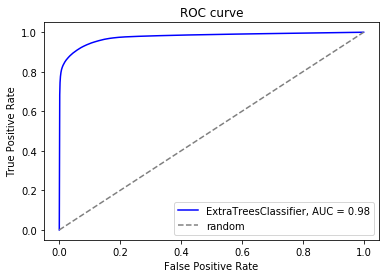

In [33]:
preds = predicted_proba[:,1]
fpr, tpr, treshold = metrics.roc_curve(expected, preds)
roc_auc = metrics.auc(fpr, tpr)
pylab.title('ROC curve')
pylab.plot(fpr, tpr,'b', label = 'ExtraTreesClassifier, AUC = %0.2f' % roc_auc)
pylab.plot([0, 1],[0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.legend(loc = 'lower right')

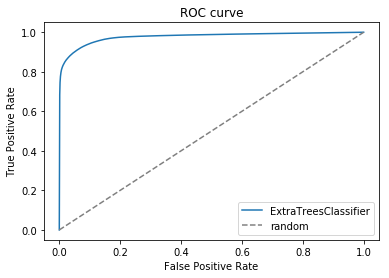

In [34]:
fpr, tpr, _ = metrics.roc_curve(expected, predicted_proba[:,1])
pylab.plot(fpr, tpr, label = 'ExtraTreesClassifier')
pylab.plot([0, 1],[0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.title('ROC curve')
pylab.legend(loc = 'lower right')

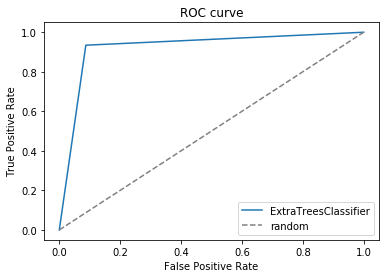

In [35]:
fpr, tpr, _ = metrics.roc_curve(expected, predicted)
pylab.plot(fpr, tpr, label = 'ExtraTreesClassifier')
pylab.plot([0, 1],[0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.title('ROC curve')
pylab.legend(loc = 'lower right')

In [36]:
print(roc_auc_score(all_y, model.predict(all_data)))
#print(roc_auc_score(all_y, ExTC.predict(all_data)))

0.9806197952372546


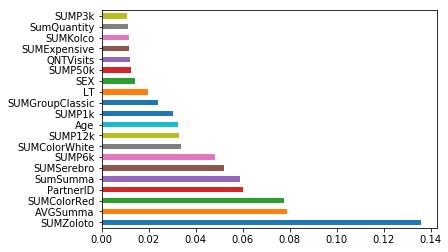

In [186]:
feat_importances = pd.Series(model.best_estimator_.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [38]:
model.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [40]:
predict = model.predict(pred)

In [41]:
predictedID_metall = pd.concat([predId,pd.DataFrame(predict,columns=['Zoloto'])],axis=1,ignore_index=False)

In [42]:
predictedID_metall.head()

,PartnerID,Zoloto
0,2,1
1,3,0
2,4,0
3,6,1
4,9,1


In [43]:
predictedID_metall['Zoloto'].value_counts()

0    2531989
1    1807964
Name: Zoloto, dtype: int64

In [44]:
predictedID_metall.to_csv('metal_pred_19122018.csv')